In [1]:
import pandas as pd
import os
import numpy as np
from IPython.display import display,display_html
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
os.chdir(r'D:\CaseStudy\demand-forecasting-kernels-only')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [131]:
#The training dataset contains 5 years of daily
#sales volumes of 50 items in 10 stores 
#(500 time series in total, from 2013 to 2017).

train = pd.read_csv('train.csv',parse_dates=['date'], index_col=[0])
test = pd.read_csv('test.csv',parse_dates=['date'], index_col=['date'])
train.sales = train.sales.astype(np.float)
#test.sales = test.sales.astype(np.float)
display_side_by_side(train.head(),test.head())

train = train[(train['store']==1)&(train['item']==1)]
test = test[(test['item']==1)&(test['store']==1)]
#The goal is to predict sales volumes of all items 
#in all stores in the first quarter of 2018. 
#The evaluation metric is SMAPE:average 2|yi−yi^|/(yi+yi^)⋅100%.
print('shape of train data ',train.shape)
print('shape of test data', test.shape)

,store,item,sales
date,,,
2013-01-01,1,1,13.0
2013-01-02,1,1,11.0
2013-01-03,1,1,14.0
2013-01-04,1,1,13.0
2013-01-05,1,1,10.0
,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1


shape of train data  (1826, 3)
shape of test data (90, 3)


In [132]:
#Data could be non-stationary
#Sales in stores could be correlated
#Data could have trend and seasonality
#Distribution may change based on time
display(pd.concat([train.isnull().sum().rename('Training NaNs'),
                   test.isnull().sum().rename('Test NaNs')], axis=1))

,Training NaNs,Test NaNs
id,NaN,0.0
item,0.0,0.0
sales,0.0,NaN
store,0.0,0.0


In [133]:
def create_features(df,sales=True):
    """
    Creates time series features from datetime index
    """
    df = df.reset_index()
    #print(df.head())
    #df.index = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if sales:
        X = df[['date','sales','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    else:
        X = df[['date','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]  
    X = X.set_index('date')
    return X

In [134]:
train_n = create_features(train)
test_n = create_features(test,sales=False)
display_side_by_side(train_n.head(),test_n.head())

sales 
 hour 
 dayofweek 
 quarter 
 month 
 year 
 dayofyear 
 dayofmonth 
 weekofyear 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-01-01 
 13.0 
 0 
 1 
 1 
 1 
 2013 
 1 
 1 
 1 
 
 
 2013-01-02 
 11.0 
 0 
 2 
 1 
 1 
 2013 
 2 
 2 
 1 
 
 
 2013-01-03 
 14.0 
 0 
 3 
 1 
 1 
 2013 
 3 
 3 
 1 
 
 
 2013-01-04 
 13.0 
 0 
 4 
 1 
 1 
 2013 
 4 
 4 
 1 
 
 
 2013-01-05 
 10.0 
 0 
 5 
 1 
 1 
 2013 
 5 
 5 
 1 
 
 
 
 
 
 
 hour 
 dayofweek 
 quarter 
 month 
 year 
 dayofyear 
 dayofmonth 
 weekofyear 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-01-01 
 0 
 0 
 1 
 1 
 2018 
 1 
 1 
 1 
 
 
 2018-01-02 
 0 
 1 
 1 
 1 
 2018 
 2 
 2 
 1 
 
 
 2018-01-03 
 0 
 2 
 1 
 1 
 2018 
 3 
 3 
 1 
 
 
 2018-01-04 
 0 
 3 
 1 
 1 
 2018 
 4 
 4 
 1 
 
 
 2018-01-05 
 0 
 4 
 1 
 1 
 2018 
 5 
 5 
 1

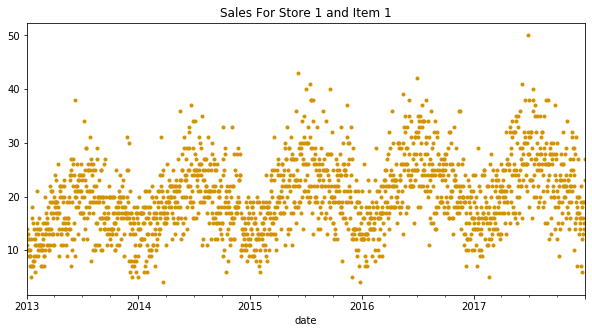

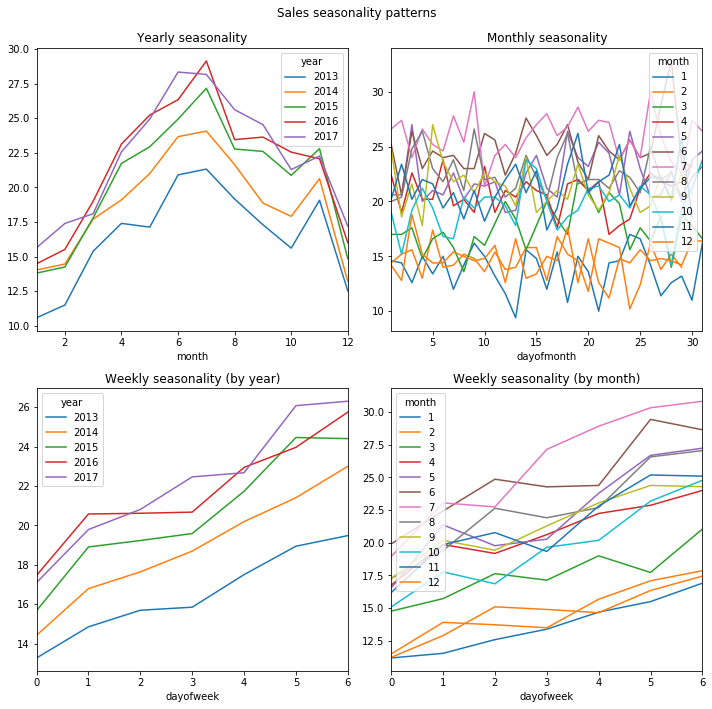

In [135]:
#Analysing seasonality pattern
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = train_n['sales'].plot(style='.', figsize=(10,5), color=color_pal[1], title='Sales For Store 1 and Item 1')
#train.groupby('date').mean()['sales'].plot(figsize=(10,3),title='Aggregated Sales');
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(train_n, values='sales', columns='year', index='month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(train_n, values='sales', columns='month', index='dayofmonth').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(train_n, values='sales', columns='year', index='dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(train_n, values='sales', columns='month', index='dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns')
fig.tight_layout(rect=[0, 0, 1, 0.96])

<Figure size 432x288 with 0 Axes>

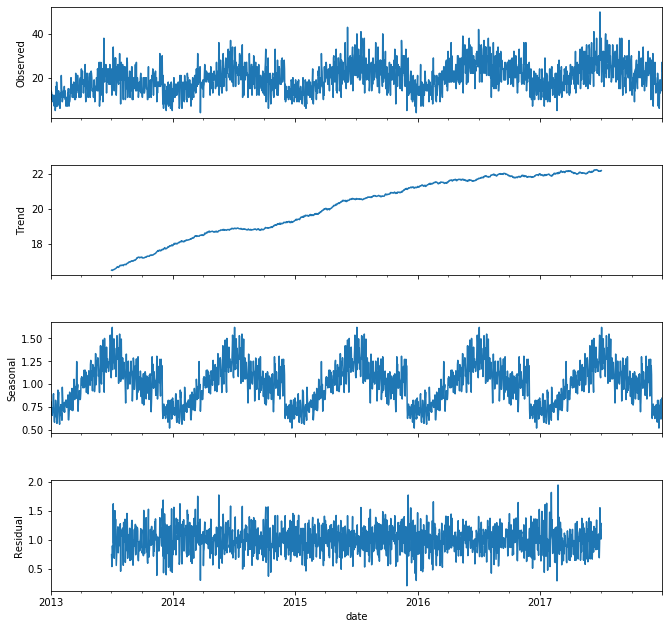

In [136]:
#Trend, Seasonality and Residual decomposition for sales in 1 store
from statsmodels.tsa.seasonal import seasonal_decompose
train_n['sales'] = train_n['sales'].astype(float)
result = seasonal_decompose(train_n['sales'], model='multiplicative', freq=365)

fig = plt.figure() ; 
fig = result.plot() ; 
fig.set_size_inches(10, 10);

In [137]:
#Non-stationarity Test and visualization
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data,column,window,cutoff=0.05):
    rolmean = data[column].rolling(window).mean()
    rolstd = data[column].rolling(window).std()
    
    #plotting statistics
    plt.figure(figsize=(12,8))
    original = plt.plot(data['sales'],color='red',label='Original data')
    rollingmean = plt.plot(rolmean,color='blue',label='Rolling Mean')
    rollingstd = plt.plot(rolstd,color ='green',label ='Rolling Std')
    plt.legend(loc='best')
    plt.title('Comparison between Rolling Mean & Std')
    plt.show()
    
    #Dickey Fuller Test
    df = adfuller(data[column],autolag='AIC',maxlag= 20)
    #dfmean = adfuller(rolmean,autolag='AIC',maxlag= 20)
    #dfstd = adfuller(rolstd,autolag='AIC',maxlag= 20)
    output=pd.Series(df[0:4],index=['Test Statistics',
                             'p-value',
                             'Lags used',
                             'Number of observations'])
    outputdf =pd.DataFrame(output)
    print(outputdf)
    #print('ADF test for original data ',df)
    #print('ADF test for Rolling Mean data ',dfmean)
    #print('ADF test for Rolling Std data ',dfstd)

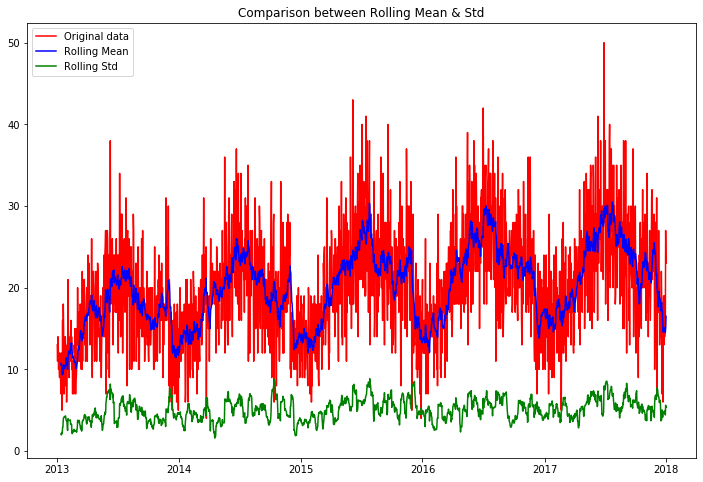

                                  0
Test Statistics           -2.987278
p-value                    0.036100
Lags used                 20.000000
Number of observations  1805.000000


In [138]:
test_stationarity(train_n,'sales',12,0.01)

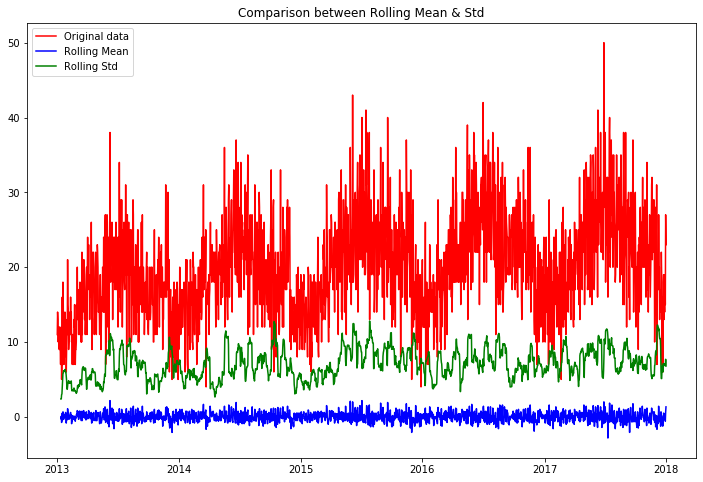

                                   0
Test Statistics        -1.520810e+01
p-value                 5.705031e-28
Lags used               2.000000e+01
Number of observations  1.804000e+03


In [139]:
#Stationarity test after 1st difference
train_n['firstdiff'] = train_n.sales-train_n.sales.shift(1)
train_n.dropna(inplace=True)
test_stationarity(train_n,'firstdiff',12,0.05)

In [140]:
#Intuition bethind ACF and PACF
#Present day sales could be due to past sales
#Similarly, future sales could be due to present day sales
#Sales at present are correlated to past sales
#ACF = Autocorrelation of sales at present and
#sales at different lags

#PACF: There are still some residuals 
#that carry correlation information with 
#previous sales. Both PACF and ACF 
#says how many factors to be taken
#into the model

from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#ACF Plot for stationary sales for store 1

def createACFandPACF(timeseries,lags=40):
    #print('ACF Values :', acf(store['firstdiff']),
          #' PACF Values :' ,pacf_ols(store['firstdiff'],nlags=20))

    plt.figure(figsize=(10,5));
    plt.title('ACF & PACF of stationary sales records')
    firstplot = lag_plot(timeseries);
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    _=plot_acf(timeseries,lags=lags,title = 'ACF Plot for 40 Lags',color='red',ax=ax[0])
    _=plot_pacf(timeseries, lags=lags,title = 'PACF Plot for 40 Lags',color='green',ax=ax[1])
    
    fig.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()
    

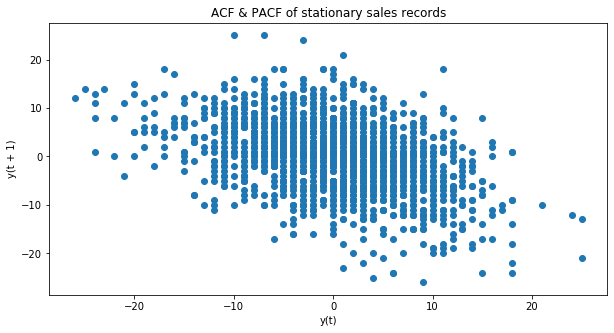

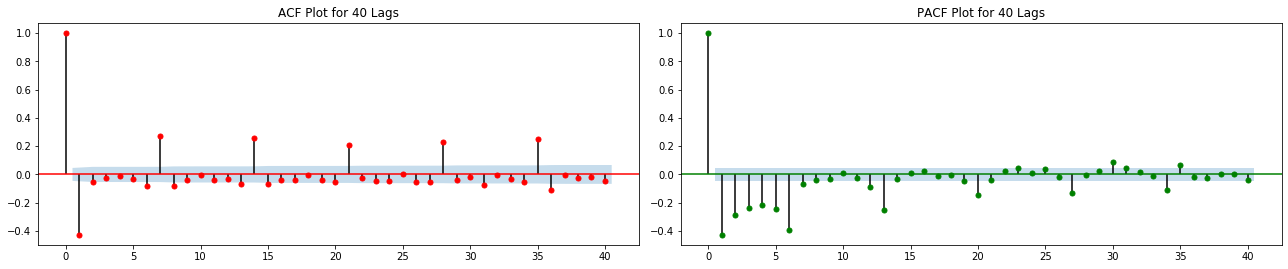

In [141]:
createACFandPACF(train_n['firstdiff'],lags=40)
#Since there are some weekly pattern 
#Seasonality should be taken into account
#SARIMA model will be build

### MODELING : ARIMA | SARIMA | AURO-ARIMA | XGBOOST | LSTM-RNN

In [142]:
#ARIMA MODEL
import statsmodels.api as sm 
model = sm.tsa.ARIMA(train_n.firstdiff,(6,0,1)).fit(disp=False)
#AR1fit=model.fit(maxlag=1)
#AR2fit=model.fit(maxlag=2)
#print('AIC for lag1 :',AR1fit.aic)
#print('AIC for lag2 :',AR2fit.aic)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:              firstdiff   No. Observations:                 1825
Model:                     ARMA(6, 1)   Log Likelihood               -5592.108
Method:                       css-mle   S.D. of innovations              5.179
Date:                Sat, 07 Mar 2020   AIC                          11202.216
Time:                        20:25:12   BIC                          11251.800
Sample:                    01-02-2013   HQIC                         11220.507
                         - 12-31-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0038      0.023      0.166      0.868      -0.041       0.049
ar.L1.firstdiff    -0.6344      0.059    -10.801      0.000      -0.750      -0.519
ar.L2.firstdiff    -0.6173      

In [143]:
#Best model out of the three 
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train_n['sales'], start_p=1, start_q=1,
                           max_p=4, max_q=4, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=10795.521, BIC=10823.046, Fit time=27.395 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=12968.175, BIC=12979.185, Fit time=0.160 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=11990.722, BIC=12012.742, Fit time=1.411 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=10793.641, BIC=10815.661, Fit time=13.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=10793.760, BIC=10821.285, Fit time=23.627 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=11826.998, BIC=11843.512, Fit time=3.148 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=10793.437, BIC=10820.962, Fit time=31.035 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=10805.875, BIC=10838.904, Fit time=46.688 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=11838.785, BIC=11860.805, Fit time=14.492 seconds
Fit ARIMA: or

### XGBOOST Model

In [144]:
#Creating multiple features for
#XGBOOST forecasting model
#store_df = create_features(store)
train_n.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,firstdiff
date,,,,,,,,,,
2013-01-02,11.0,0,2,1,1,2013,2,2,1,-2.0
2013-01-03,14.0,0,3,1,1,2013,3,3,1,3.0
2013-01-04,13.0,0,4,1,1,2013,4,4,1,-1.0
2013-01-05,10.0,0,5,1,1,2013,5,5,1,-3.0
2013-01-06,12.0,0,6,1,1,2013,6,6,1,2.0


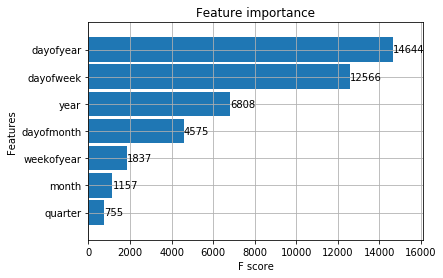

In [151]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
X = train_n.drop(['firstdiff','sales'],axis=1)
Y = train_n['sales']
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X,Y,verbose=False)
_ = plot_importance(reg, height=0.9)

In [195]:
#We need to use previous monthly sales data to 
#forecast the next ones. The look-back period may 
#vary for every model. Ours will be 12 for this example
for i in range(1,13):
    field_name='lag_'+str(i)
    sales[field_name]=sales['diff'].shift(i)

In [196]:
#drop null values
sales = sales.dropna().reset_index(drop=True)
sales.head()

,Newdate,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117.0,525987.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301.0,529117.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914.0,704301.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877.0,788914.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842.0,882877.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [ ]:
traindata = sales.drop(columns=['N'])

In [1]:
#LSTM with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Scaling the date
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit(sales.resha)